<a href="https://colab.research.google.com/github/Rogerx98/twsm-group-project/blob/main/SentenceBERT_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comment:

Inspiration 1 for Multi-label: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

Inspiration 2 for MultiLabelBinarizer = https://github.com/pnageshkar/NLP/blob/master/Medium/Multi_label_Classification_BERT_Lightning.ipynb

# **Libraries**

In [2]:
!pip install transformers 
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.7 MB/s 
     |████████████████████████████████| 596 kB 64.9 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 101 kB 14.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification, TFBertModel, BertConfig, TFBertForSequenceClassification, TFDistilBertForSequenceClassification
import tensorflow as tf
import tensorflow_hub as hub

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer

from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import BertForSequenceClassification
from tensorflow.keras.layers import Input, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM
from keras.layers.core import Activation, Dropout, Dense

import tensorflow as tf

np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#since most of our numbers will be decimals :)

from tensorflow.keras.metrics import AUC

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Dataset**

In [5]:
df = pd.read_csv("/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/twsm_project_corpus2.csv") #Roger main google acc
#df = pd.read_csv("/content/drive/MyDrive/twsm_project_corpus0.csv") #Roger second google acc
#df = pd.read_csv("/content/drive/MyDrive/twsm/twsm_project_corpus0.csv", index_col = 0) #valentins drive
#df = pd.read_csv("/home/valentin_werner/TWSM_Lab_Team4/twsm_project_corpus0.csv", index_col = 0) on zeno
df.head(5)
df = df.dropna() #drop na values (somehow a few remained in the dataset)
rejoined = [row.split(" ") for row in df.labels_str]
df["accept"] = rejoined
df.head(10)

,Unnamed: 0,text,accept,labels_str
0,0,The other part of our data consists of an undi...,[Data],Data
1,1,This list of actors can be interpreted to repr...,[Definition],Definition
2,2,The two samples were compared on all study var...,"[Method, Theory]",Method Theory
3,3,This is supported by a more recent report by ...,[RelationToLiterature],RelationToLiterature
4,4,", the false noise parameter C was misstated by...",[Definition],Definition
5,5,"In the strategic management literature, the na...",[RelationToLiterature],RelationToLiterature
6,6,"No such link was found however, but, according...",[FutureWork],FutureWork
7,7,The problem is that the timeliness of the data...,"[Data, Limitation]",Data Limitation
8,8,The social sciences differ from the physical s...,[RelationToLiterature],RelationToLiterature
9,9,Browne et al. START_CITE [3] END_CITE CITE_b...,[RelationToLiterature],RelationToLiterature


## **Preprocess Text**

In [6]:
#@title
def pre_process(text):
  text = BeautifulSoup(text).get_text()
  # fetch alphabetic characters
  #text = re.sub("[^a-zA-Z]", " ", text)
  # convert text to lower case
  text = text.lower()
  # split text into tokens to remove whitespaces
  tokens = text.split()
  return " ".join(tokens)

In [7]:
#@title
df["clean_text"] = df["text"].apply(pre_process)

In [8]:
#@title
df["text"][3]

'This is supported by a more recent report by  START_CITE West and Curtis (2006) END_CITE  CITE_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [9]:
#@title
df["clean_text"][3]

'this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.'

In [10]:
df["clean_text"]

0       the other part of our data consists of an undi...
1       this list of actors can be interpreted to repr...
2       the two samples were compared on all study var...
3       this is supported by a more recent report by s...
4       , the false noise parameter c was misstated by...
                              ...                        
2283    however, we can also confirm that the zero-pri...
2284    this enabled rapid publication of the games an...
2285    the trusting attitude items assessed subjects'...
2286    when we zoom out onto a collective, organizati...
2287    this continued reciprocity generates a seeming...
Name: clean_text, Length: 2283, dtype: object

In [11]:
pd.set_option('display.max_colwidth', None)

clean_text = df[df['clean_text'].str.contains('cite')]
#clean_text["clean_text"].head(5)
clean_text["clean_text"]

3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                this is supported by a more recent report by start_cite west and curtis (2006) end_cite cite_b72 , which found significant differences between women and men academics, including disparities in tenure and salaries.
5       in the strategic management literature, the nature of the risk/return relationship was found to be contingent on a number of factors, all subject to managerial discretion: prior firm performance start_cite (fiegenbaum and thomas, 1986; end_cite cite_b18 start_cite chang and thomas

In [12]:
df["clean_text"]

0                                                                                                                                                                                                                                                                                                                                                                                                           the other part of our data consists of an undirected social graph.
1                                                                                                                                                                                                                                                                                                                                               this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.
2                                                                         

In [13]:
import re

new_text = [re.sub("start_cite|end_cite|cite_\w+", "", text) for text in df["clean_text"]]
#new_text = [re.sub('\s(?=[\.,:;])', '', text) for text in df["text"]]
df["clean_text"] = new_text
df["clean_text"][0:5]

0                                                                                                                             the other part of our data consists of an undirected social graph.
1                                                                 this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.
2                                                                                  the two samples were compared on all study variables and on age, gender, position, and organizational tenure.
3    this is supported by a more recent report by  west and curtis (2006)   , which found significant differences between women and men academics, including disparities in tenure and salaries.
4                                                             , the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).
Name: clean_text, dtype: object

## **Max_len decision**

Text(0, 0.5, 'Word count')

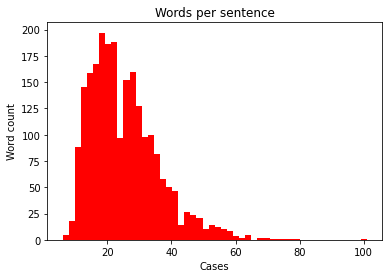

In [14]:
#Count words per sentence so we can set an appropiate max_len. In this case, 200 will be more than enough.
word_list = [len(x.split()) for x in df["clean_text"].tolist()]
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
n, bins, patches = ax.hist(word_list, bins=50, histtype='bar')

#ax.set_xticklabels([n], rotation='vertical')

for patch in patches:
    patch.set_facecolor('r')

plt.title("Words per sentence")
plt.xlabel('Cases')
plt.ylabel('Word count')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


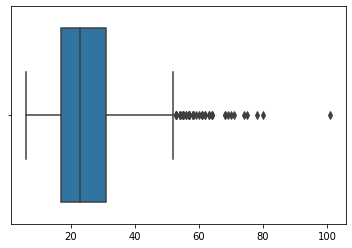

In [15]:
sns.boxplot(word_list)

In [16]:
np.count_nonzero(np.array(word_list) >= 75)
#maximum length of 75 is fine!

#recheck this after removing start-cite, end-cite etc

4

# **Keras Model**

In [17]:
#lets turn "accept" into a column that properly lists the labels (right now it is a string of a list instead of a list of strings)
rejoined = np.array([row.split(" ") for row in df.labels_str])
df["accept"] = rejoined
df_new = df[["clean_text", "accept"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [18]:
rejoined

array([list(['Data']), list(['Definition']), list(['Method', 'Theory']),
       ..., list(['RelationToLiterature']), list(['Definition']),
       list(['Definition'])], dtype=object)

In [19]:
df_new = df_new.reset_index().drop(columns = "index")
df_new.columns = ["text", "label"]

In [20]:
df_new.head()

,text,label
0,the other part of our data consists of an undirected social graph.,[Data]
1,this list of actors can be interpreted to represent the most important barriers to successful software development in nigeria.,[Definition]
2,"the two samples were compared on all study variables and on age, gender, position, and organizational tenure.","[Method, Theory]"
3,"this is supported by a more recent report by west and curtis (2006) , which found significant differences between women and men academics, including disparities in tenure and salaries.",[RelationToLiterature]
4,", the false noise parameter c was misstated by 0.10 (either all high or all low in a run) except near the end points (c = 0 or 1).",[Definition]


In [21]:
# First Split for Train and Test
#we should stratify, but we have some groups that have only one
train_df, test_df = train_test_split(df_new, test_size=0.3, random_state= 0)#, stratify = df_new.label.values)

# Next split test in to test and validation
val_df = test_df.sample(frac = 0.667)
test_df = test_df.drop(val_df.index)

#70% train, 20% val, 10% test
print(train_df.shape[0], val_df.shape[0], test_df.shape[0])

1598 457 228


In [22]:
#encoding labels with keras Lookup Layer
terms = tf.ragged.constant(df_new["label"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print(f"Vocabulary: {vocab}")
#the UNK token will always also be returned.

Vocabulary: ['[UNK]', 'Theory', 'RelationToLiterature', 'Method', 'Definition', 'EmpiricalResult', 'Contribution', 'Motivation', 'Data', 'Item', 'Goal', 'Limitation', 'HypothesisResult', 'FutureWork', 'ResearchQuestion', 'Hypothesis']


In [23]:
#Example
sample_label = df_new["label"].iloc[2]
label_binarized = lookup([sample_label])
label_binarized, sample_label
#Note: Unlike the OHE with sklearn, this is not ordered alphabetically but in the order we can find below (including the UNK token)

(<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
 array([[0.000000, 1.000000, 0.000000, 1.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000]], dtype=float32)>,
 ['Method', 'Theory'])

Inspo:
 
https://www.kaggle.com/code/samarthagarwal23/0-81-tf-keras-deberta-baseline-single-model

https://keras.io/examples/nlp/multi_label_classification/ 

In [24]:
#Our Config (so we can reference this values in later code and avoid spaghetti)
seed = 0
epochs = 8 ###
#num_folds = 5, #set folds later on
max_length = 75
batch_size = 8
learning_rate = 2e-5 ## lower l r higher epoch (2/3 was initial config)
base_model = "bert-large-uncased" ###BertForSequenceClassification 

In [25]:
#Prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
def tok(x): return tokenizer(x, padding = True, truncation = True, return_tensors = "tf", max_length = max_length)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [26]:
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["label"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        #because tokenizing becomes more dificult afterwards (hugginface clashes a little with keras), I already tokenize here
        ((tok(list(dataframe.text))["input_ids"], tok(list(dataframe.text))["attention_mask"])
        #not using the token type since we are not using special tokens anyways
        ,label_binarized)
    )
    #take batches randomly along the whole dataset
    dataset = dataset.shuffle(batch_size * ((dataframe.shape[0] // batch_size) + 1)) if is_train else dataset
    return dataset.batch(batch_size)

In [27]:
#get datasets
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [28]:
test_dataset

<BatchDataset element_spec=((TensorSpec(shape=(None, 75), dtype=tf.int32, name=None), TensorSpec(shape=(None, 75), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>

In [29]:
def get_labels_out(dataset):
    labels = []
    for element in dataset:
        for arr in element[1]:
            labels.append(np.array(arr))
    labels = np.asarray(labels)
    return labels

In [30]:
#One example input and (decoded) output from the train dataset
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[0][:3]):
    label = label_batch[i].numpy()
    print(f"Tokens: {text}")
    print(f"Label(s): {invert_multi_hot(label)}")
#the first three will be our input

Tokens: [  101  2947  1010  2057  3582  2023  2470  2000 17158  4697  4471 10061
  2791  2241  2006  2367  9530  3367  6820  9777  1010  2566 18856  2102
  1012   102     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
Label(s): ['Method']
Tokens: [ 101 1996 2047 4395 1998 9412 2009 9859 2020 3107 1999 3674 5711 1012
  102    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Label(s): ['Method']
Tokens: [  101  1996  2003  9009  2003  2926 10897  2000  2107  9934  2138  1997
  2049 12042  3037  1

In [31]:
"""#Val try
def build_model():
    
    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    
    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)
    x = bert(input_ids = input_ids, attention_mask = input_mask)

    #this is for finetuning (tinkering with last layers)
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.1)(x) ############ 
    fnl = tf.keras.layers.Dense(lookup.vocabulary_size(), activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = [input_ids, input_mask], 
                           outputs = fnl)
    return model"""

'#Val try\ndef build_model():\n    \n    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)\n    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)\n    \n    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)\n    x = bert(input_ids = input_ids, attention_mask = input_mask)\n\n    #this is for finetuning (tinkering with last layers)\n    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)\n    x = tf.keras.layers.Dropout(0.1)(x) ############ \n    fnl = tf.keras.layers.Dense(lookup.vocabulary_size(), activation=\'sigmoid\')(x)\n    \n    model = tf.keras.Model(inputs = [input_ids, input_mask], \n                           outputs = fnl)\n    return model'

## **Actual accuracy is measured with Multi_label_accuracy defined next. Simple Accuracy of Tries might not be a ideal lead as they weren't calculated with multi_label_acc. Updated accuracies written down manually after fitting**

In [32]:
#Multi Label Accuracy For Multiple Labels Classification Models (https://data4thought.com/toxic_comments_transformer.html)
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [33]:
#Roger lab
def build_model():
    
    input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
    
    bert = transformers.TFAutoModel.from_pretrained(base_model, num_labels=15, problem_type="multi_label", trainable=True)
    x = bert(input_ids = input_ids, attention_mask = input_mask) 

    #this is for finetuning
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.15)(x)
    out = tf.keras.layers.Dense(lookup.vocabulary_size(), activation='softmax')(x) #####
    
    model = tf.keras.Model(inputs = [input_ids, input_mask], 
                           outputs = out)
    return model

# **BertForSequenceClassification seems to be useful for similar tasks, couldnt apply it successfully yet**

In [34]:
###BertForSequenceClassification
#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

In [35]:
###BertForSequenceClassification

#model = build_model()
#model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
#model.summary()

In [36]:
###BertForSequenceClassification
#input_ids = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)
#input_mask = tf.keras.Input(shape=(max_length, ), dtype = tf.int32)

In [37]:
###BertForSequenceClassification
#model.fit(train_dataset,batch_size=32,epochs=4,validation_data= validation_dataset)

In [38]:
model = build_model()
model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), ######learning rate
        loss = "binary_crossentropy", ########################
        metrics = [
          multi_label_accuracy,
          "binary_accuracy", 
          AUC(name="average_precision", curve="PR", multi_label=True)
          ]
    )
model.summary()

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 75,                                            

In [39]:
def scheduler(epoch):
    learning_rate
    if epoch == 0: return learning_rate * 0.15
    if epoch == 1: return learning_rate * 0.3
    else: return learning_rate / (epoch**0.35) # more epochs = lower the number

In [40]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor="val_multi_label_accuracy",#'val_categorical_accuracy', 
                                               patience=4,
                                               mode='max', 
                                               verbose=1,
                                               restore_best_weights=True)

callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

callback_save = tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2.h5', monitor='val_multi_label_accuracy',  #save model in drive(github) #change name
        #"/content/drive/MyDrive/Output models Bert/RogerSentenceBert2", monitor='val_multi_label_accuracy',
        verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', 
        save_freq='epoch')

In [41]:
model.fit(train_dataset, 
        epochs = 20, #### finetuning
        shuffle=True,
        callbacks = [callback_lr,
                      callback_es,
                      callback_save,
                     ],
        batch_size = 8,
        validation_data = validation_dataset
       )


Epoch 1: LearningRateScheduler setting learning rate to 3e-06.
Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.2806 - multi_label_accuracy: 0.0200 - binary_accuracy: 0.9222 - average_precision: 0.1107
Epoch 1: val_multi_label_accuracy improved from -inf to 0.11422, saving model to /content/drive/Othercomputers/Mi portátil/Master/GitHub/twsm-group-project/keras_model/RogerSentenceBert2.h5
200/200 [==============================] - 157s 629ms/step - loss: 0.2806 - multi_label_accuracy: 0.0200 - binary_accuracy: 0.9222 - average_precision: 0.1107 - val_loss: 0.2204 - val_multi_label_accuracy: 0.1142 - val_binary_accuracy: 0.9270 - val_average_precision: 0.1842 - lr: 3.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 6e-06.
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.2035 - multi_label_accuracy: 0.1890 - binary_accuracy: 0.9292 - average_precision: 0.1958
Epoch 2: val_multi_label_accuracy improved from 0.11422 to 0.2004

In [42]:
lr = learning_rate
def scheduler(epoch, multiplier):
    learning_rate = lr
    if epoch == 0: return learning_rate * 0.15
    if epoch == 1: return learning_rate * 0.3
    else: return learning_rate / (epoch** multiplier)

In [43]:
e20m01 = [scheduler(epoch, 0.1) for epoch in range(20)]
e20m02 = [scheduler(epoch, 0.2) for epoch in range(20)]
e20m03 = [scheduler(epoch, 0.3) for epoch in range(20)]
e20m04 = [scheduler(epoch, 0.4) for epoch in range(20)]
e20m05 = [scheduler(epoch, 0.5) for epoch in range(20)]
e20m06 = [scheduler(epoch, 0.6) for epoch in range(20)]
e20m07 = [scheduler(epoch, 0.7) for epoch in range(20)]

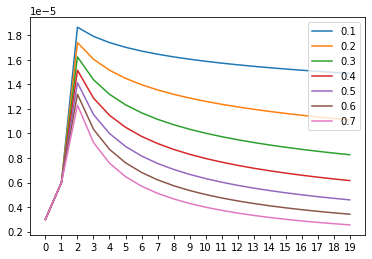

In [44]:
plt.plot(e20m01, label = "0.1")
plt.plot(e20m02, label = "0.2")
plt.plot(e20m03, label = "0.3")
plt.plot(e20m04, label = "0.4")
plt.plot(e20m05, label = "0.5")
plt.plot(e20m06, label = "0.6")
plt.plot(e20m07, label = "0.7")
plt.legend()
plt.xticks(range(20)); 

# 1st try

* learning rate: 4e-5
* epochs: 8
* model: 1st try roger
* loss: 0.0611 - multi_label_accuracy: 0.6737 - binary_accuracy: 0.9726 - average_precision: 0.7886 - val_loss: 0.2770 - **val_multi_label_accuracy: 0.3220** - val_binary_accuracy: 0.9197 - val_average_precision: 0.3875

# 2.

* *learning rate: 5e-5 #horrendous*

# 3.

* learning rate: 3e-5
* epochs: 8
* model: 2nd try roger 
* loss: 0.1482 - multi_label_accuracy: 0.4215 - binary_accuracy: 0.9468 - average_precision: 0.5725 - val_loss: 0.2975 - **val_multi_label_accuracy: 0.31439** - val_binary_accuracy: 0.9195 - val_average_precision: 0.0786

# 4

* learning rate: 4e-5
* epochs: 8
* model: 2nd try roger (Play with 0.1-0,2 dropout)
* loss: 0.0317 - multi_label_accuracy: 0.6858 - binary_accuracy: 0.9747 - average_precision: 0.8811 - val_loss: 0.2564 - **val_multi_label_accuracy: 0.3447** - val_binary_accuracy: 0.9256 - val_average_precision: 0.3905 

# 5

* learning rate: 1e-5
* epochs: 8
* model: 1st try roger 0,2 dropout
* loss: 0.0816 - multi_label_accuracy: 0.5896 - binary_accuracy: 0.9648 - average_precision: 0.7828 - val_loss: 0.2149 - **val_multi_label_accuracy: 0.3333** - val_binary_accuracy: 0.9258 - val_average_precision: 0.3763

# 6

* learning rate: 2e-5
* epochs: 8
* model: 1st try roger 0,2 dropout
* loss: 0.0194 - multi_label_accuracy: 0.7013 - binary_accuracy: 0.9766 - average_precision: 0.8919 - val_loss: 0.2766 - **val_multi_label_accuracy: 0.3447** - val_binary_accuracy: 0.9234 - val_average_precision: 0.3933

# 7 (with lr decay)

* learning rate: 2e-5
* epochs: 20
* lr grow: 0,30
* loss: 0.0409 - multi_label_accuracy: 0.6936 - binary_accuracy: 0.9744 - average_precision: 0.8741 - val_loss: 0.2318 - **val_multi_label_accuracy: 0.3485** - val_binary_accuracy: 0.9292 - val_average_precision: 0.3724 - lr: 1.1156e-05

# 8 (with lr decay)
* learning rate: 2e-5
* epochs: 20
* activation: sigmoid
* dropout: 0,15
* lr grow: 0,35
* loss: 0.0346 - multi_label_accuracy: 0.8806 - binary_accuracy: 0.9916 - average_precision: 0.9155 - val_loss: 0.2494 - **val_multi_label_accuracy: 0.3254** - val_binary_accuracy: 0.9301 - val_average_precision: 0.3486 - lr: 1.0122e-05

# 9 (with lr decay)

* model: bert-large-uncased
* learning rate: 2e-5
* epochs: 20
* activation: softmax
* dropout: 0,15
* lr grow: 0,35
* loss: 0.0445 - multi_label_accuracy: 0.7446 - binary_accuracy: 0.9793 - average_precision: 0.8325 - val_loss: 0.2585 - **val_multi_label_accuracy: 0.3815**- val_binary_accuracy: 0.9267 - val_average_precision: 0.3269 - lr: 1.0683e-05


In [45]:
preds = model.predict(test_dataset)
#preds[preds>=0.5] = 1
#preds[preds<0.5] = 0

In [46]:
test_labels = get_labels_out(test_dataset)

In [47]:

np.set_printoptions(formatter={'float_kind':'{:f}'.format})


for i, labels in enumerate(test_labels[:-5]):
    print(f"index {i}: \n predictions: \n {preds[i]} \n real labels: \n {test_labels[i]}")

index 0: 
 predictions: 
 [0.000003 0.000001 0.000048 0.999183 0.000001 0.000000 0.000023 0.000005
 0.000677 0.000013 0.000006 0.000012 0.000005 0.000013 0.000006 0.000003] 
 real labels: 
 [0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
index 1: 
 predictions: 
 [0.002516 0.001908 0.001251 0.002091 0.031047 0.039529 0.023179 0.734851
 0.003287 0.001178 0.001097 0.142298 0.001301 0.013186 0.000851 0.000429] 
 real labels: 
 [0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000]
index 2: 
 predictions: 
 [0.000144 0.000308 0.001730 0.000439 0.000139 0.009590 0.963162 0.001694
 0.001182 0.000356 0.013094 0.000303 0.001324 0.006205 0.000241 0.000088] 
 real labels: 
 [0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000

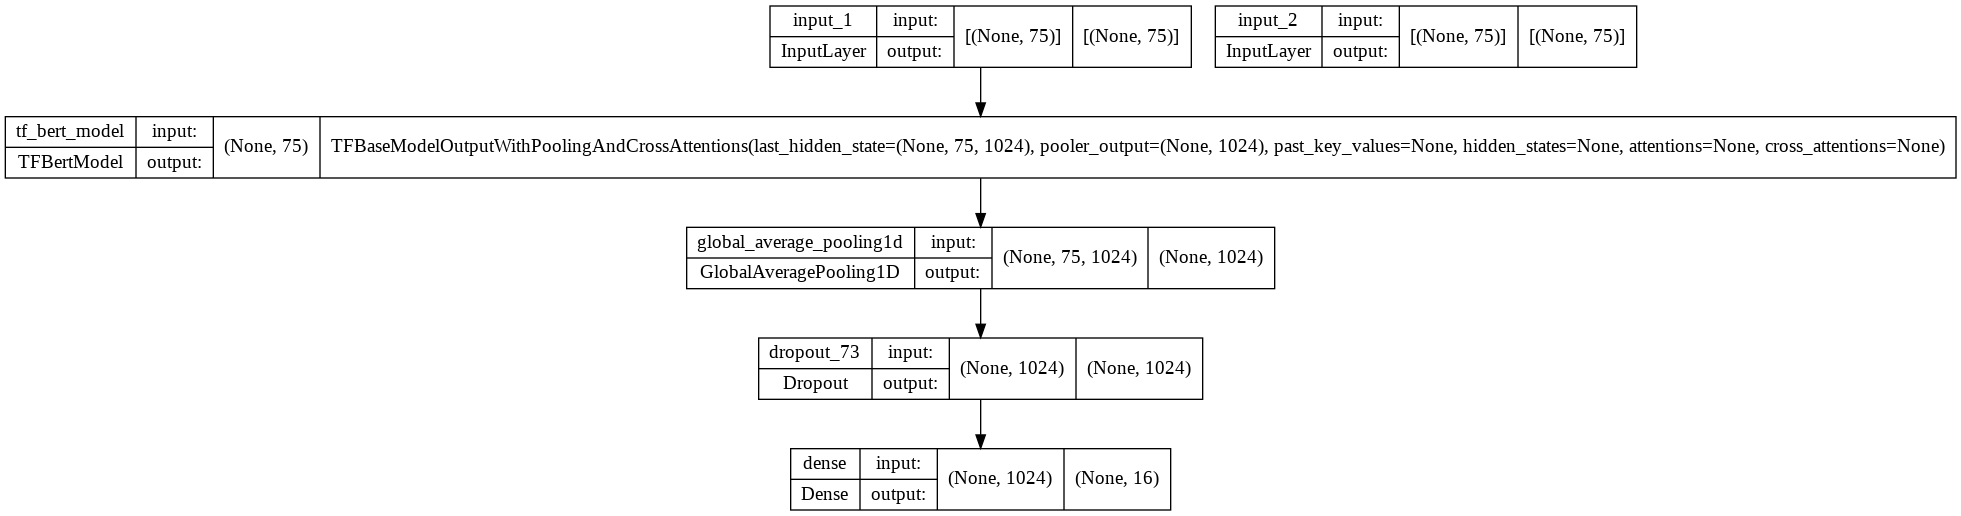

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# Threshold for predictions, reference code 


In [49]:
THRESHOLD = 0.5

encoding = tokenizer.encode_plus(
  test_comment, #######input
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"]) ######input trained_model
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

NameError: ignored

# Inference

# Retrain with new params

# Re-Inference